In [271]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import gymnasium as gym
from gymnasium import spaces


In [272]:
GRID_SIZE = 10
COLUMNS = 10
ROWS = 10

In [273]:
class GridEnvImpar(gym.Env):
    def __init__(self):
        super(GridEnvImpar, self).__init__()
        self.action_space = spaces.Discrete(4) # Up, Down, Left, Right
        self.observation_space = spaces.Box(low=np.array([0, 0]), high=np.array([ROWS - 1, COLUMNS - 1]), dtype=np.int32)
        self.reward_map = None
        self.step_counter = 0
        self.total_rewards_collected = 0
        self.reset()

    def reset(self):
        self.state = np.array([0, 0]) # Starting at top-left corner
        self.initialize_reward_map()
        self.step_counter = 0  # Reset the step counter at the start of each episode
        self.total_rewards_collected = 0
        return self.state

    def initialize_reward_map(self):
        self.reward_map = np.full((ROWS, COLUMNS), 1)
        # self.reward_map[self.state[0], self.state[1]] = 100  # Set the starting column to 0
        # self.reward_map[ROWS-1,0] = 100
        # self.reward_map[-1, :] = 100  # Set the bottom row to 100

    def step(self, action):
        # Initialize done as False
        done = False
        reward = 0.
        # Action mappings (no changes here)
        action_mappings = {
            0: (-1, 0),  # Move up
            1: (1, 0),   # Move down
            2: (0, -1),  # Move left
            3: (0, 1)    # Move right
        }
        
        # Update state based on action with x, y format
        delta = action_mappings.get(action, (0, 0))
        new_state = np.array([self.state[0] + delta[0], self.state[1] + delta[1]])

        # Check and handle boundary conditions
        if new_state[0] < 0 or new_state[0] >= ROWS or new_state[1] < 0 or new_state[1] >= COLUMNS:
            # print(f"Out of bounds in [{new_state[0]}, {new_state[1]}]")
            reward = -100
            done = True
        else:
            self.state = new_state
            self.step_counter += 1
            reward = self.calculate_reward()
            done = self.is_done()
            if done:
                reward = 100
            
            y = self.state[0]
            x = self.state[1]
            self.reward_map[y,x] = -1

        # Check if goal is reached and update the reward map
        # if y == ROWS - 1 and x == 0 and self.total_rewards_collected == 0: 
        #     print("Goal 1 reached")
        #     self.total_rewards_collected += 1
        #     self.reward_map = np.full((ROWS, COLUMNS), -1)
        #     self.reward_map[ROWS-1, 1] = 100  # Set new goal
        # if y == ROWS - 1 and x == 1 and self.total_rewards_collected == 1:
        #     done = True
        
        return self.state, reward, done, {}

        
    def calculate_reward(self):
        # Check if the agent has reached the bottom of the grid
        # if self.state[0] == self.grid_size - 1:
        #     return 100
        # print(f"Reward obtained: {self.reward_map[self.state[0], self.state[1]]}")
        return self.reward_map[self.state[0], self.state[1]]        

    def is_done(self):
        # Check if all cells in the grid have been visited or if a step limit is reached
        max_steps = 100  # Example step limit
        return np.all(self.reward_map == -1) or self.step_counter >= max_steps            
        
    def render(self, mode='human'):
        plt.figure(figsize=(5, 5))
        plt.imshow(self.reward_map, cmap='viridis', origin='lower')
        plt.scatter(self.state[1], self.state[0], c='red', marker='o')  # Agent's position
        plt.title("Agent's movement in Grid")
        plt.pause(0.1)  # Pause for a short period to create animation effect
        

In [274]:
def train_agent(env, agent, episodes):
    best_total_reward = -float('inf')
    best_path = []

    for episode in range(episodes):
        state = env.reset()
        current_path = [state]
        done = False
        total_reward = 0

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            current_path.append(state)

        if total_reward > best_total_reward:
            best_total_reward = total_reward
            best_path = current_path

        if episode % 10 == 0:
            print(f"Episode {episode}: Total Reward: {total_reward}")

    return best_path


In [275]:
class QLearningAgentImpar:
    def __init__(self, env, learning_rate=0.2, discount_factor=0.9, epsilon=0.1, gasoline_capacity=1000, wheat_capacity=100):
        self.env = env
        self.gasoline = gasoline_capacity  # Initial gasoline level
        self.wheat = 0  # Initial wheat level
        self.gasoline_capacity = gasoline_capacity
        self.wheat_capacity = wheat_capacity

        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = np.zeros((ROWS, COLUMNS, env.action_space.n))

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = self.env.action_space.sample()  # Random action
        else:
            state_index = (state[0], state[1])
            action = np.argmax(self.q_table[state_index])
        return action
    
    def learn(self, state, action, reward, next_state):
        state_index = (state[0], state[1])
        next_state_index = (next_state[0], next_state[1])
        # Update rule for Q-learning
        best_next_action = np.argmax(self.q_table[next_state_index])
        td_target = reward + self.discount_factor * self.q_table[next_state_index][best_next_action]
        td_error = td_target - self.q_table[state_index][action]
        self.q_table[state_index][action] += self.learning_rate * td_error

    def train(self, episodes):
        for _ in range(episodes):
            state = self.env.reset()
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.learn(state, action, reward, next_state)
                state = next_state


In [276]:
# Train the agent
env = GridEnvImpar()
agent = QLearningAgentImpar(env)
best_path = train_agent(env, agent, episodes=20000)


Episode 0: Total Reward: -100
Episode 10: Total Reward: -95
Episode 20: Total Reward: -86
Episode 30: Total Reward: -94
Episode 40: Total Reward: -93
Episode 50: Total Reward: 77
Episode 60: Total Reward: 43
Episode 70: Total Reward: 49
Episode 80: Total Reward: 45
Episode 90: Total Reward: 33
Episode 100: Total Reward: 39
Episode 110: Total Reward: 39
Episode 120: Total Reward: 39
Episode 130: Total Reward: 35
Episode 140: Total Reward: 41
Episode 150: Total Reward: 33
Episode 160: Total Reward: 47
Episode 170: Total Reward: 39
Episode 180: Total Reward: 51
Episode 190: Total Reward: -97
Episode 200: Total Reward: 31
Episode 210: Total Reward: 45
Episode 220: Total Reward: 59
Episode 230: Total Reward: 49
Episode 240: Total Reward: 57
Episode 250: Total Reward: -97
Episode 260: Total Reward: 47
Episode 270: Total Reward: -96
Episode 280: Total Reward: -99
Episode 290: Total Reward: 59
Episode 300: Total Reward: -94
Episode 310: Total Reward: 55
Episode 320: Total Reward: 31
Episode 33

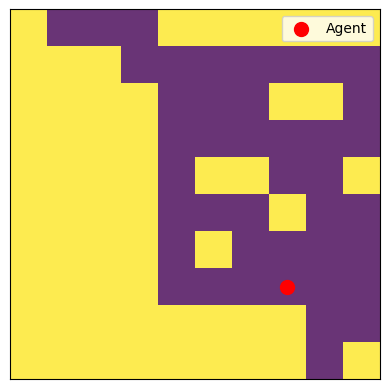

In [277]:
def animation_plot(env, ax):
    ax.clear()
    ax.imshow(env.reward_map, cmap='viridis', alpha=0.8)
    ax.scatter(env.state[1], env.state[0], color='red', label='Agent', s=100)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend()

# print(env.reward_map)
def update(frame, env, agent, ax):
    if not hasattr(update, "done") or not update.done:
        action = agent.choose_action(env.state)
        _, _, update.done, _ = env.step(action)
        animation_plot(env, ax)

fig, ax = plt.subplots()

# Reset the environment for the animation
env.reset()

# Create the animation
animation = FuncAnimation(fig, lambda frame: update(frame, env, agent, ax), frames=100, interval=100)

# Display the animation in Jupyter Notebook
HTML(animation.to_jshtml())


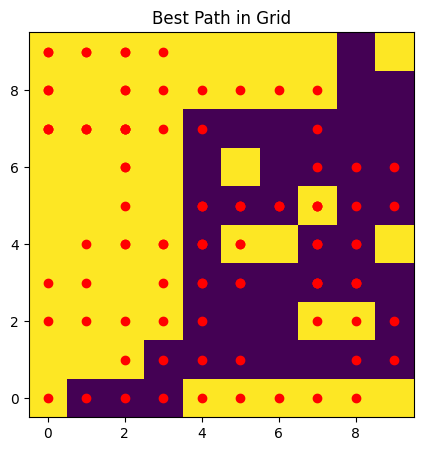

[array([0, 0]), array([0, 1]), array([0, 2]), array([1, 2]), array([2, 2]), array([2, 1]), array([2, 0]), array([3, 0]), array([3, 1]), array([4, 1]), array([4, 2]), array([4, 3]), array([4, 4]), array([5, 4]), array([5, 5]), array([5, 6]), array([5, 7]), array([4, 7]), array([3, 7]), array([3, 8]), array([2, 8]), array([2, 9]), array([1, 9]), array([1, 8]), array([0, 8]), array([0, 7]), array([0, 6]), array([0, 5]), array([1, 5]), array([1, 4]), array([0, 4]), array([0, 3]), array([1, 3]), array([2, 3]), array([2, 4]), array([3, 4]), array([3, 5]), array([4, 5]), array([4, 4]), array([5, 4]), array([5, 5]), array([5, 6]), array([5, 7]), array([4, 7]), array([3, 7]), array([3, 8]), array([4, 8]), array([4, 7]), array([3, 7]), array([2, 7]), array([3, 7]), array([3, 8]), array([4, 8]), array([5, 8]), array([5, 9]), array([6, 9]), array([6, 8]), array([6, 7]), array([7, 7]), array([8, 7]), array([8, 6]), array([8, 5]), array([8, 4]), array([7, 4]), array([7, 3]), array([8, 3]), array([9,

In [278]:
def plot_best_path(env, best_path):
    plt.figure(figsize=(5, 5))
    plt.imshow(env.reward_map, cmap='viridis', origin='lower')

    # Plot the path
    for state in best_path:
        plt.scatter(state[1], state[0], c='red', marker='o')

    plt.title("Best Path in Grid")
    plt.show()
plot_best_path(env, best_path)
print(best_path)

In [279]:
def transform_path(original_path, iteration):
    transformed_path = []
    ROWS = 10  # Assuming the number of rows is constant at 10

    for x, y in original_path:
        if iteration % 2 == 1:
            # For odd iterations, increase x and increment y
            new_x = x
            new_y = y + (iteration - 1)
        else:
            # For even iterations, decrease x and increment y
            new_x = ROWS - 1 - x
            new_y = y + (iteration - 1)
        
        transformed_path.append(np.array([new_x, new_y]))

    # Add the last point of the iteration
    if iteration % 2 == 1:
        transformed_path.append(np.array([ROWS - 1, transformed_path[-1][1] + 1]))
    else:
        transformed_path.append(np.array([0, transformed_path[-1][1] + 1]))

    return transformed_path

for iteration in range(1, 4):
    print(f"Iteration {iteration}: {transform_path(best_path, iteration)}")

Iteration 1: [array([0, 0]), array([0, 1]), array([0, 2]), array([1, 2]), array([2, 2]), array([2, 1]), array([2, 0]), array([3, 0]), array([3, 1]), array([4, 1]), array([4, 2]), array([4, 3]), array([4, 4]), array([5, 4]), array([5, 5]), array([5, 6]), array([5, 7]), array([4, 7]), array([3, 7]), array([3, 8]), array([2, 8]), array([2, 9]), array([1, 9]), array([1, 8]), array([0, 8]), array([0, 7]), array([0, 6]), array([0, 5]), array([1, 5]), array([1, 4]), array([0, 4]), array([0, 3]), array([1, 3]), array([2, 3]), array([2, 4]), array([3, 4]), array([3, 5]), array([4, 5]), array([4, 4]), array([5, 4]), array([5, 5]), array([5, 6]), array([5, 7]), array([4, 7]), array([3, 7]), array([3, 8]), array([4, 8]), array([4, 7]), array([3, 7]), array([2, 7]), array([3, 7]), array([3, 8]), array([4, 8]), array([5, 8]), array([5, 9]), array([6, 9]), array([6, 8]), array([6, 7]), array([7, 7]), array([8, 7]), array([8, 6]), array([8, 5]), array([8, 4]), array([7, 4]), array([7, 3]), array([8, 3

In [280]:
# def plot_q_values(agent):
#     fig, axs = plt.subplots(agent.env.grid_size, agent.env.grid_size, figsize=(20, 20))

#     # Iterate over all grid cells
#     for i in range(agent.env.grid_size):
#         for j in range(agent.env.grid_size):
#             ax = axs[i, j]
#             q_values = agent.q_table[i, j]

#             # Use a bar chart or similar to represent Q-values for each action
#             ax.bar(range(len(q_values)), q_values, color=['blue', 'green', 'red', 'purple'])
#             ax.set_ylim([-100, 100])  # Assuming Q-values are in this range; adjust as needed
#             ax.set_xticks(range(len(q_values)))
#             ax.set_xticklabels(['Up', 'Down', 'Left', 'Right'])
#             ax.set_title(f"State ({i}, {j})")

#     plt.tight_layout()
#     plt.show()

# # Assuming your agent is named 'agent' and has been trained
# plot_q_values(agent)